# CITY LIFE. Geospatial analysis

### Task

In this project, you will try to get some valuable insights about customers’
and taxi drivers’ behavior. Maybe it will help a taxi company optimize its
business.
Here are the tasks that you need to do:
1. find out and visualize on a map most popular areas where people ordered a taxi as
well as where they headed to,
2. find out and visualize the most popular routes in different time intervals,
3. find in the dataset locations of the city infrastructure and visualize how the customers were arriving at one of them using an animated map,
4. visualize one day of a taxi driver and how much money he or she earned using an
animated map,
5. visualize one day of the city (working day and weekend day) using an animated
map.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !pip install taxicab


In [3]:
from IPython.utils import io

# with io.capture_output() as captured:
#     foo()

In [4]:
import geopandas as gpd
# import geoplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import folium
import seaborn as sns
import osmnx as ox
import networkx as nx
import time
import geopy
import taxicab as tc

from tqdm import tqdm

tiles='Mapbox',

from mpl_toolkits.axes_grid1 import make_axes_locatable

from shapely.geometry import Polygon, LineString, Point, MultiPoint
from shapely.ops import unary_union

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull

from datetime import datetime

from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

from kneed import KneeLocator


### Load data

In [5]:
df_map = gpd.read_file('data/chicago_map.shx')

In [6]:
df_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  77 non-null     geometry
dtypes: geometry(1)
memory usage: 744.0 bytes


In [7]:
rush = pd.read_csv('data/rush_hours_empty.csv',
                   parse_dates=['Trip End Timestamp'],
                   dtype={
                       'name': str,
                       'longitude': float,
                       'latitude': float,
                       'num_of_rides': int,
                         })

In [8]:
rush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                1 non-null      object        
 1   longitude           1 non-null      float64       
 2   latitude            1 non-null      float64       
 3   num_of_rides        1 non-null      int64         
 4   Trip End Timestamp  1 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 168.0+ bytes


In [9]:
taxi_loc = pd.read_csv('data/taxi_locations.csv',
                       parse_dates=['Trip Start Timestamp', 
                                    'Trip End Timestamp'],
                       index_col='Trip ID',
                       dtype={
                           'Pickup Centroid Latitude': float,
                           'Pickup Centroid Longitude': float,
                           'Dropoff Centroid Latitude': float,
                           'Dropoff Centroid Longitude': float,
                           'Taxi ID': str,
                           'Fare': float  
                       }
                      )

In [10]:
taxi_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2506294 entries, 304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea to 21b2d9d623e7a51ad43032bd758a1321e63217e1
Data columns (total 10 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Pickup Centroid Latitude    float64       
 1   Pickup Centroid Longitude   float64       
 2   Pickup Centroid Location    object        
 3   Dropoff Centroid Latitude   float64       
 4   Dropoff Centroid Longitude  float64       
 5   Dropoff Centroid  Location  object        
 6   Trip Start Timestamp        datetime64[ns]
 7   Trip End Timestamp          datetime64[ns]
 8   Taxi ID                     object        
 9   Fare                        float64       
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 210.3+ MB


### Data preparation

Set crs to be able to combine dataframes

In [11]:
df_map.set_crs(epsg=4326, inplace=True)
crs = {'init':'EPSG:4326'}

Create folium map to visualize data in the shapefile (Chicago map)

In [12]:
m = folium.Map(location=[41.85, -87.65], zoom_start=10, tiles='CartoDB positron')

Add df_map data to folium map to visualize polygons (districts) on the real map

In [13]:
for _, r in df_map.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)

In [14]:
m

### Dropoff and Pickup columns to geometry type

In [15]:
taxi_loc['Pickup Centroid Location'] = gpd.GeoSeries.from_wkt(taxi_loc['Pickup Centroid Location'])
taxi_loc['Dropoff Centroid  Location'] = gpd.GeoSeries.from_wkt(taxi_loc['Dropoff Centroid  Location'])

In [16]:
taxi_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2506294 entries, 304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea to 21b2d9d623e7a51ad43032bd758a1321e63217e1
Data columns (total 10 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Pickup Centroid Latitude    float64       
 1   Pickup Centroid Longitude   float64       
 2   Pickup Centroid Location    geometry      
 3   Dropoff Centroid Latitude   float64       
 4   Dropoff Centroid Longitude  float64       
 5   Dropoff Centroid  Location  geometry      
 6   Trip Start Timestamp        datetime64[ns]
 7   Trip End Timestamp          datetime64[ns]
 8   Taxi ID                     object        
 9   Fare                        float64       
dtypes: datetime64[ns](2), float64(5), geometry(2), object(1)
memory usage: 210.3+ MB


### Check for NaN values and duplicates

In [17]:
taxi_loc.isna().sum()

Pickup Centroid Latitude        0
Pickup Centroid Longitude       0
Pickup Centroid Location        0
Dropoff Centroid Latitude       0
Dropoff Centroid Longitude      0
Dropoff Centroid  Location      0
Trip Start Timestamp            0
Trip End Timestamp              0
Taxi ID                         1
Fare                          196
dtype: int64

In [18]:
taxi_loc = taxi_loc.drop_duplicates()

In [19]:
taxi_loc_no_zero_trip = taxi_loc.drop(index=taxi_loc[taxi_loc['Pickup Centroid Location']==taxi_loc['Dropoff Centroid  Location']].index)

In [20]:
taxi_loc_no_zero_trip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2192465 entries, 304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea to 21b2d9d623e7a51ad43032bd758a1321e63217e1
Data columns (total 10 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Pickup Centroid Latitude    float64       
 1   Pickup Centroid Longitude   float64       
 2   Pickup Centroid Location    geometry      
 3   Dropoff Centroid Latitude   float64       
 4   Dropoff Centroid Longitude  float64       
 5   Dropoff Centroid  Location  geometry      
 6   Trip Start Timestamp        datetime64[ns]
 7   Trip End Timestamp          datetime64[ns]
 8   Taxi ID                     object        
 9   Fare                        float64       
dtypes: datetime64[ns](2), float64(5), geometry(2), object(1)
memory usage: 184.0+ MB


## 1. Most popular areas

### 1.1 Clustering analysis

Conduct clustering analysis of pick point and drop off locations based on their coordinates. Clusters might be different for each of the categories (pickpoints and drop-offs).

### Pickpoints

In [21]:
pickups = taxi_loc_no_zero_trip[['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location']]

In [22]:
pickup_coords = pickups[['Pickup Centroid Longitude', 'Pickup Centroid Latitude']]

We need to define the best number of clusters. In order to do this we can use elbow rule

#### K-means algorythm

##### Elbow curve

100%|██████████████████████████████████████████████████████████████████████| 19/19 [00:29<00:00,  1.57s/it]


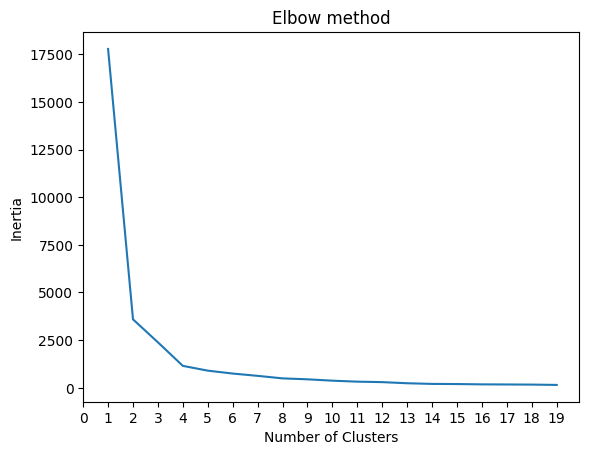

In [23]:
inertia=[]
for i in tqdm(range(1,20)):
    kmeans = KMeans(n_clusters=i,random_state=42, n_init='auto').fit(pickup_coords)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,20),inertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(0,20,1))
plt.show()

4? clasters is optimal

##### Silhouette value

In [24]:
# score=-1
# k=0
# for i in tqdm(range(2,20)):
#     kmeans = KMeans(n_clusters=i,random_state=0, n_init='auto').fit(pickup_coords.values)
#     score2 = silhouette_score(pickup_coords.values,kmeans.predict(pickup_coords.values))
#     if score2>score:
#         score=score2
#         k=i
# print('The best number of clusters based on silhouette score is {} with a score of {}.'.format(k,score))

##### Elbow kneed lib

In [25]:
elbow_point = KneeLocator(range(1,20),inertia,curve='convex',direction='decreasing')
print(elbow_point.knee)

4


Fitting kmeans model for pickpoints

In [26]:
n_clusters = 10

In [27]:
kmeans_pick = KMeans(
    init="k-means++",
    n_clusters=n_clusters,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [28]:
kmeans_pick.fit(pickups[pickups.columns[0:2]]) # Compute k-means clustering.
pickups['pickup_cluster_kmeans'] = kmeans_pick.fit_predict(pickups[pickups.columns[0:2]])
pickups_centers = kmeans_pick.cluster_centers_ # Coordinates of cluster centers.
pickups_labels = kmeans_pick.predict(pickups[pickups.columns[0:2]]) # Labels of each point
pickups.head(5)

/tmp/ipykernel_7599/237264503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pickups['pickup_cluster_kmeans'] = kmeans_pick.fit_predict(pickups[pickups.columns[0:2]])


,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,pickup_cluster_kmeans
Trip ID,,,,
304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,41.878866,-87.625192,POINT (-87.62519 41.87887),4
b1a8b95ea294663cc3d3cb38a538f464418288c4,41.947792,-87.683835,POINT (-87.68383 41.94779),2
01428cb986d678ea0a8d39b6b35d05d06baa631a,41.892042,-87.631864,POINT (-87.63186 41.89204),4
5e9ddc495e4afb24df4af7d3763cabc78ba08d2b,41.899156,-87.626211,POINT (-87.62621 41.89916),4
4b8e0d0faf7dd670e0b703c77c40ee226e343a94,41.899602,-87.633308,POINT (-87.63331 41.89960),4


Creating a geo dataframe from cluster centers points

In [29]:
pickups_centers = pd.DataFrame(pickups_centers, columns=['lat', 'long'])

In [30]:
pickup_centers_coords = pickups_centers[['long', 'lat']].values

In [31]:
geometry = [Point(xy) for xy in zip(pickups_centers['long'], pickups_centers['lat'])]
geo_pickups_centers = gpd.GeoDataFrame(pickups_centers, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [32]:
geo_pickups_centers

,lat,long,geometry
0,41.880659,-87.639945,POINT (-87.63994 41.88066)
1,41.979395,-87.905875,POINT (-87.90587 41.97940)
2,41.961662,-87.663157,POINT (-87.66316 41.96166)
3,41.788011,-87.754330,POINT (-87.75433 41.78801)
4,41.891582,-87.625791,POINT (-87.62579 41.89158)
5,41.764540,-87.602521,POINT (-87.60252 41.76454)
6,41.957663,-87.741244,POINT (-87.74124 41.95766)
7,41.923841,-87.646116,POINT (-87.64612 41.92384)
8,41.906270,-87.684288,POINT (-87.68429 41.90627)
9,41.857245,-87.621077,POINT (-87.62108 41.85724)


#### DBSCAN algorythm

In [33]:
pickup_coords_val = pickup_coords.values #Create a numpy array


In [34]:
# nearest_neighbors = NearestNeighbors(n_neighbors=6)
# neighbors = nearest_neighbors.fit(pickup_coords_val)
# distances, indices = neighbors.kneighbors(pickup_coords_val)
# distances = np.sort(distances[:,5], axis=0)
# i = np.arange(len(distances))
# knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
# # We use the polynomial interp_method in this one to get a smooth line
# fig = plt.figure(figsize=(5, 5))
# knee.plot_knee()
# plt.xlabel("Points")
# plt.ylabel("Distance")
# plt.show()
# print('The elbow point is at around {}'.format(round(distances[knee.knee],3)))

In [35]:
# dbscan = DBSCAN(eps=0.045)
# dbscan.fit(pickup_coords_val)
# dbscan_predictions = dbscan.labels_
# pickups['Cluster_DBSCAN'] = dbscan_predictions
# vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
# # pickups['Colors_DBSCAN'] = vectorizer(dbscan_predictions)

Other clustering algos

Mean-shift algorythm, Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM), Agglomerative Hierarchical Clustering

### Drop-offs

In [36]:
dropoffs = taxi_loc_no_zero_trip[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']]
dropoff_coords = dropoffs[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']]

#### Elbow curve

100%|██████████████████████████████████████████████████████████████████████| 19/19 [00:26<00:00,  1.41s/it]


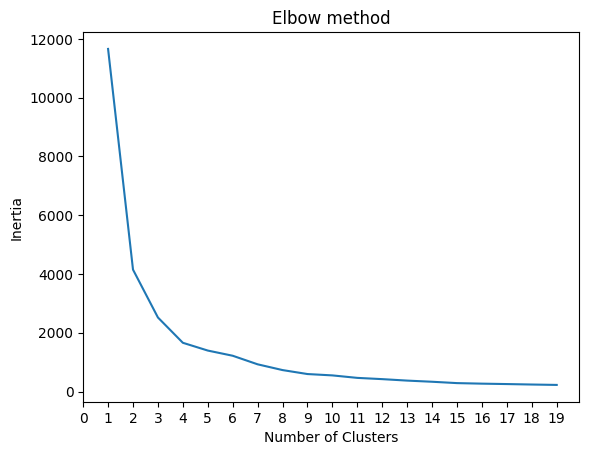

In [37]:
inertia=[]
for i in tqdm(range(1,20)):
    kmeans = KMeans(n_clusters=i,random_state=0, n_init='auto').fit(dropoff_coords)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,20),inertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(0,20,1))
plt.show()

4 clusters is optimal

##### Elbow kneed lib

In [38]:
elbow_point = KneeLocator(range(1,20),inertia,curve='convex',direction='decreasing')
print(elbow_point.knee)

4


In [39]:
n_clusters = 15

In [40]:
kmeans_drop = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [41]:
kmeans_drop.fit(dropoffs[dropoffs.columns[0:2]]) # Compute k-means clustering.
dropoffs['dropoff_cluster_kmeans'] = kmeans_drop.fit_predict(dropoffs[dropoffs.columns[0:2]])
dropoffs_centers = kmeans_drop.cluster_centers_ # Coordinates of cluster centers.
dropoffs_labels = kmeans_drop.predict(dropoffs[dropoffs.columns[0:2]]) # Labels of each point
dropoffs.head(5)

/tmp/ipykernel_7599/4257850880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropoffs['dropoff_cluster_kmeans'] = kmeans_drop.fit_predict(dropoffs[dropoffs.columns[0:2]])


,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,dropoff_cluster_kmeans
Trip ID,,,,
304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,41.778877,-87.594925,POINT (-87.59493 41.77888),8
b1a8b95ea294663cc3d3cb38a538f464418288c4,41.874005,-87.663518,POINT (-87.66352 41.87401),9
01428cb986d678ea0a8d39b6b35d05d06baa631a,41.979071,-87.903040,POINT (-87.90304 41.97907),14
5e9ddc495e4afb24df4af7d3763cabc78ba08d2b,41.929078,-87.646293,POINT (-87.64629 41.92908),13
4b8e0d0faf7dd670e0b703c77c40ee226e343a94,41.947792,-87.683835,POINT (-87.68383 41.94779),10


In [42]:
dropoffs_centers = pd.DataFrame(dropoffs_centers, columns=['lat', 'long'])
dropoff_centers_coords = dropoffs_centers[['long', 'lat']].values

In [43]:
geometry = [Point(xy) for xy in zip(dropoffs_centers['long'], dropoffs_centers['lat'])]
geo_dropoffs_centers = gpd.GeoDataFrame(dropoffs_centers, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [44]:
geo_dropoffs_centers

,lat,long,geometry
0,41.879708,-87.635580,POINT (-87.63558 41.87971)
1,41.853181,-87.622307,POINT (-87.62231 41.85318)
2,41.789275,-87.749400,POINT (-87.74940 41.78927)
3,41.893780,-87.618833,POINT (-87.61883 41.89378)
4,41.891279,-87.642335,POINT (-87.64234 41.89128)
5,41.897715,-87.629521,POINT (-87.62952 41.89771)
6,41.881094,-87.621842,POINT (-87.62184 41.88109)
7,41.935400,-87.712349,POINT (-87.71235 41.93540)
8,41.791430,-87.597909,POINT (-87.59791 41.79143)
9,41.886620,-87.667149,POINT (-87.66715 41.88662)


### 1.2 Cluster borders and centroids

Draw the borders and centroids of the clusters on a map. You will have two maps.

Prepare data and make polygons for pickup clusters (Voronoi diagram)

<!-- ### Pickups -->

In [45]:
geometry = pickups['Pickup Centroid Location']
geo_pickups = gpd.GeoDataFrame(pickups, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [46]:
area = df_map.unary_union

In [47]:
geo_pickups_centers

,lat,long,geometry
0,41.880659,-87.639945,POINT (-87.63994 41.88066)
1,41.979395,-87.905875,POINT (-87.90587 41.97940)
2,41.961662,-87.663157,POINT (-87.66316 41.96166)
3,41.788011,-87.754330,POINT (-87.75433 41.78801)
4,41.891582,-87.625791,POINT (-87.62579 41.89158)
5,41.764540,-87.602521,POINT (-87.60252 41.76454)
6,41.957663,-87.741244,POINT (-87.74124 41.95766)
7,41.923841,-87.646116,POINT (-87.64612 41.92384)
8,41.906270,-87.684288,POINT (-87.68429 41.90627)
9,41.857245,-87.621077,POINT (-87.62108 41.85724)


In [48]:
pickup_polys, pickup_pts = voronoi_regions_from_coords(pickup_centers_coords, area)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in 

In [49]:
pickup_polys_df = pd.DataFrame.from_dict(pickup_polys, orient='index')
pickup_polys_df = gpd.GeoDataFrame(pickup_polys_df, geometry=0)


Prepare data and make polygons fro dropoff clusters

In [50]:
geometry = dropoffs['Dropoff Centroid  Location']
geo_dropoffs = gpd.GeoDataFrame(dropoffs, 
                          crs = crs, 
                          geometry = geometry)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [51]:
dropoff_polys, dropoff_pts = voronoi_regions_from_coords(dropoff_centers_coords, area)
dropoff_polys_df = pd.DataFrame.from_dict(dropoff_polys, orient='index')
dropoff_polys_df = gpd.GeoDataFrame(dropoff_polys_df, geometry=0)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in 

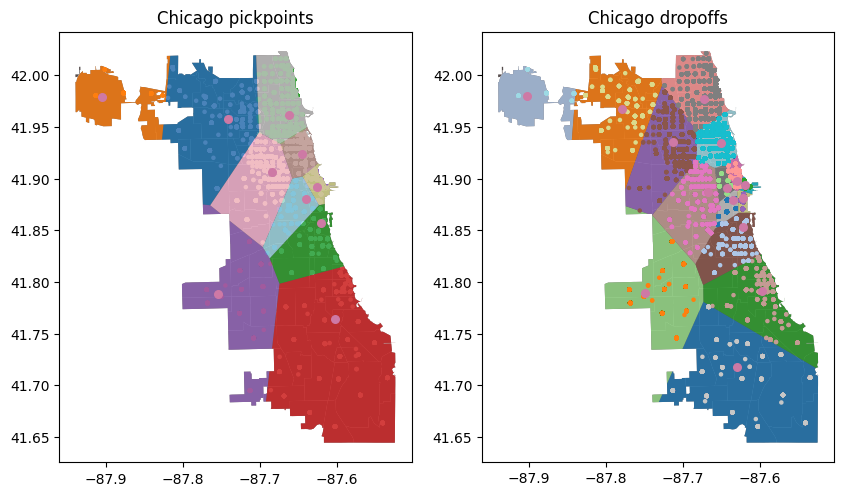

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = (10,10))
df_map.plot(ax=ax1, color='#554d4d', legend=True, )
geo_pickups.plot(ax=ax1, cmap='tab20', column='pickup_cluster_kmeans', markersize=5)
pickup_polys_df.plot(ax=ax1, cmap='tab20', column=0, alpha=0.8)
ax1.set_title('Chicago pickpoints')
geo_pickups_centers.plot(ax=ax1, color='#ce79a5', markersize=30)

df_map.plot(ax=ax2, color='#554d4d', legend=True, )
dropoff_polys_df.plot(ax=ax2, cmap='tab20', column=0, alpha=0.8)
geo_dropoffs.plot(ax=ax2, cmap='tab20', column='dropoff_cluster_kmeans', markersize=5)
ax2.set_title('Chicago dropoffs')
geo_dropoffs_centers.plot(ax=ax2, color='#ce79a5', markersize=30)


plt.show()

### 1.3. Largest number of pick points and drop-offs

<!-- ### 7687

Use a color scale to show which clusters (i.e. areas) have the largest number of pick
points and drop-offs.

#### Pickups

In [53]:
pickups_clusters = pickups.groupby('pickup_cluster_kmeans')['Pickup Centroid Location'].count()
pickups_clusters.sort_values(ascending=False)
pickups_clusters_df = pd.DataFrame(pickups_clusters)
pickups_clusters_df = pickups_clusters_df.rename(columns={'Pickup Centroid Location': 'kmeans_cluster_observations'}).reset_index()

In [54]:
pickup_polys_df_ = pickup_polys_df.reset_index().rename(columns={'index': 'pickup_cluster_kmeans'})
pickup_polys_df_ = pickup_polys_df_.merge(pickups_clusters_df, on='pickup_cluster_kmeans')

#### Dropoffs

In [55]:
dropoffs_clusters = dropoffs.groupby('dropoff_cluster_kmeans')['Dropoff Centroid  Location'].count()
dropoffs_clusters.sort_values(ascending=False)
dropoffs_clusters_df = pd.DataFrame(dropoffs_clusters)
dropoffs_clusters_df = dropoffs_clusters_df.rename(columns={'Dropoff Centroid  Location': 'kmeans_cluster_observations'}).reset_index()

In [56]:
dropoff_polys_df_ = dropoff_polys_df.reset_index().rename(columns={'index': 'dropoff_cluster_kmeans'})
dropoff_polys_df_ = dropoff_polys_df_.merge(dropoffs_clusters_df, on='dropoff_cluster_kmeans')

In [57]:
dropoff_polys_df_

,dropoff_cluster_kmeans,0,kmeans_cluster_observations
0,0,"POLYGON ((-87.69606 41.68807, -87.69609 41.688...",332137
1,1,"POLYGON ((-87.84491 41.93738, -87.84516 41.937...",108209
2,2,"MULTIPOLYGON (((-87.72715 41.99001, -87.77495 ...",32992
3,3,"POLYGON ((-87.67352 41.78084, -87.67375 41.797...",197037
4,4,"MULTIPOLYGON (((-87.74491 41.86590, -87.74508 ...",157275
5,5,"POLYGON ((-87.72715 41.99001, -87.72780 41.997...",430336
6,6,"POLYGON ((-87.73983 41.86461, -87.73994 41.864...",261112
7,7,"POLYGON ((-87.67375 41.79716, -87.68391 41.817...",62597
8,8,"POLYGON ((-87.65260 41.87753, -87.65823 41.851...",27123
9,9,"POLYGON ((-87.62668 41.88894, -87.62944 41.887...",166306


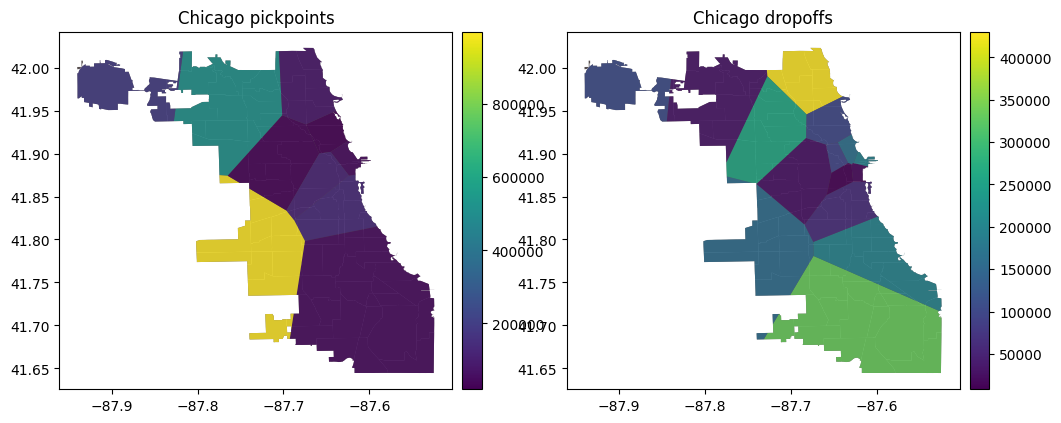

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,10))
df_map.plot(ax=ax1, color='#554d4d')
# geo_pickups.plot(ax=ax1, cmap='Set2', column='pickup_cluster_kmeans', markersize=5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
pickup_polys_df_.plot(ax=ax1, cax=cax, cmap='viridis', column='kmeans_cluster_observations', alpha=0.8, legend=True)
ax1.set_title('Chicago pickpoints')
# geo_pickups_centers.plot(ax=ax1, color='#e2c1d2', markersize=30)

df_map.plot(ax=ax2, color='#554d4d')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
dropoff_polys_df_.plot(ax=ax2, cax=cax, cmap='viridis', column='kmeans_cluster_observations', alpha=0.8, legend=True)
# geo_dropoffs.plot(ax=ax2, cmap='Set2', column='dropoff_cluster_kmeans', markersize=5)
ax2.set_title('Chicago dropoffs')
# geo_dropoffs_centers.plot(ax=ax2, color='#e2c1d2', markersize=30)


plt.show()

## 2. Most popular routes

### 2.1 Clustering analysis

Conduct a clustering analysis of taxi rides based on the coordinates of the pick
point location and drop off.

In [59]:
routes = taxi_loc_no_zero_trip[['Pickup Centroid Longitude', 'Pickup Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid Latitude']]
routes_val = routes.values

100%|██████████████████████████████████████████████████████████████████████| 19/19 [00:38<00:00,  2.00s/it]


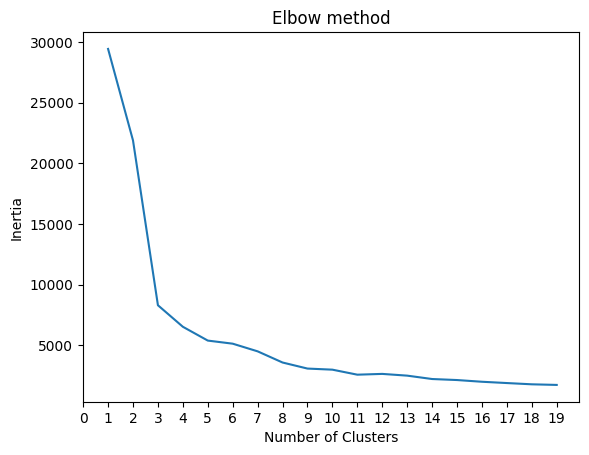

In [60]:
inertia=[]
for i in tqdm(range(1,20)):
    kmeans = KMeans(n_clusters=i,random_state=42, n_init='auto').fit(routes_val)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,20),inertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(0,20,1))
plt.show()

In [61]:
elbow_point = KneeLocator(range(1,20),inertia,curve='convex',direction='decreasing')
print(elbow_point.knee)

4


In [62]:
n_clusters = 15

In [63]:
kmeans_routes = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init='auto',
    max_iter=300,
    random_state=42
)

In [64]:
kmeans_routes.fit(routes_val) # Compute k-means clustering.
routes['routes_cluster_kmeans'] = kmeans_routes.fit_predict(routes_val)
routes_centers = kmeans_routes.cluster_centers_ # Coordinates of cluster centers.
routes_labels = kmeans_routes.predict(routes_val) # Labels of each point
routes.head(5)

/tmp/ipykernel_7599/2691231120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes['routes_cluster_kmeans'] = kmeans_routes.fit_predict(routes_val)


,Pickup Centroid Longitude,Pickup Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Latitude,routes_cluster_kmeans
Trip ID,,,,,
304a88bf5d8a7d60c1dbfd88661caa15ee4cb0ea,-87.625192,41.878866,-87.594925,41.778877,5
b1a8b95ea294663cc3d3cb38a538f464418288c4,-87.683835,41.947792,-87.663518,41.874005,10
01428cb986d678ea0a8d39b6b35d05d06baa631a,-87.631864,41.892042,-87.903040,41.979071,2
5e9ddc495e4afb24df4af7d3763cabc78ba08d2b,-87.626211,41.899156,-87.646293,41.929078,6
4b8e0d0faf7dd670e0b703c77c40ee226e343a94,-87.633308,41.899602,-87.683835,41.947792,6


In [65]:
routes_centers_df = pd.DataFrame(routes_centers, columns=['Pickup Centroid Longitude', 'Pickup Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid Latitude'])

In [66]:
routes[routes['routes_cluster_kmeans']==8]

,Pickup Centroid Longitude,Pickup Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Latitude,routes_cluster_kmeans
Trip ID,,,,,
73113e32b472fefb7a1fc0e85d41377beaf2db92,-87.632746,41.880994,-87.626215,41.892508,8
a824bc82d6f690050a422793bf8e7cc2fd6f1e1c,-87.631864,41.892042,-87.626215,41.892508,8
9ef5b1c8897cb79edb17bb24db8a3202c40743d9,-87.632746,41.880994,-87.634156,41.922083,8
eca41a0ab46b1fe71c1c8853dc120cc164631e65,-87.626215,41.892508,-87.626211,41.899156,8
4de84f1501d7553b8f1cc5d2cc3557b4b2e6596b,-87.621972,41.877406,-87.619711,41.895033,8
...,...,...,...,...,...
21bd51046b4d043c39d47882d87809a9fd1f0ab4,-87.632746,41.880994,-87.626211,41.899156,8
21b7f8d90c70b81a15324b51f70f9e8fb7fd4229,-87.620993,41.884987,-87.637844,41.893216,8
21b080daab47546e2fc63815e8c8f444157e1fc8,-87.618868,41.890922,-87.620763,41.898332,8


In [67]:
geometry = [MultiPoint([(x,y),(j,k)]) for x,y,j,k in zip(routes_centers_df['Pickup Centroid Longitude'], 
                                           routes_centers_df['Pickup Centroid Latitude'],
                                          routes_centers_df['Dropoff Centroid Longitude'],
                                           routes_centers_df['Dropoff Centroid Latitude'])]
geo_routes_centers = gpd.GeoDataFrame(routes_centers_df, crs=crs, geometry=geometry)
geo_routes_centers = geo_routes_centers.reset_index()

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [68]:
routes_clusters = routes.groupby('routes_cluster_kmeans')['Pickup Centroid Longitude'].count()


In [69]:
top_clusters = routes_clusters.sort_values(ascending=False)[0:5].index

In [70]:
top_clusters

Int64Index([8, 14, 0, 7, 3], dtype='int64', name='routes_cluster_kmeans')

### 2.2 Centroids

Draw centroids of the top 5 popular clusters (routes).

In [71]:
geo_top_routes = geo_routes_centers.iloc[top_clusters]

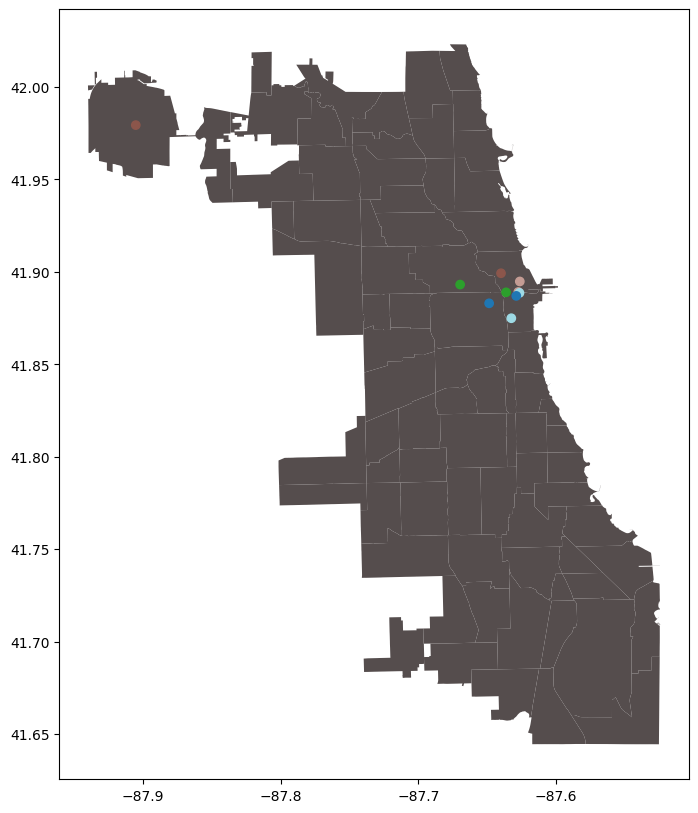

In [72]:
fig, ax = plt.subplots(figsize = (12,10))
df_map.plot(ax=ax, color='#554d4d')
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", size="5%", pad=0.1)
geo_top_routes.plot(ax=ax, cmap='tab20', column='index',)
ax1.set_title('Chicago routes')

plt.show()

### 2.3 Draw routes

Draw routes between centroids of a cluster – not a direct line from point A to point
B, but a path that takes into account the city streets.

In [73]:
ox.config(log_console=True, use_cache=True)
place = 'Chicago, United States'
mode = 'drive' # 'drive', 'bike', 'walk'
# graph = ox.graph_from_place(place, network_type = mode)

/home/toptish/PycharmProjects/virtual_envs/citylife/lib/python3.9/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [74]:
graph = ox.graph_from_polygon(polygon = area, network_type = mode)

In [75]:
def get_route(graph, start_latlng, end_latlng):
    # find shortest route based on the mode of travel
#     mode = 'drive' # 'drive', 'bike', 'walk'

    # find shortest path based on distance or time
    optimizer = 'time' # 'length','time'

    # find the nearest node to the start location
    orig_node = ox.nearest_nodes(graph, start_latlng[1], start_latlng[0])

    # find the nearest node to the end location
    dest_node = ox.nearest_nodes(graph, end_latlng[1], end_latlng[0])

    # find the shortest path
    shortest_route = nx.shortest_path(graph, orig_node,dest_node,
                                      weight=optimizer)
    return shortest_route

In [76]:
top_routes = [get_route(graph, (r['Pickup Centroid Latitude'], r['Pickup Centroid Longitude']), (r['Dropoff Centroid Latitude'], r['Dropoff Centroid Longitude'])) for _, r in geo_top_routes.iterrows()]

In [77]:
top_routes_taxicab = [tc.distance.shortest_path(graph, (r['Pickup Centroid Latitude'], r['Pickup Centroid Longitude']), (r['Dropoff Centroid Latitude'], r['Dropoff Centroid Longitude'])) for _, r in geo_top_routes.iterrows()]

In [78]:
shortest_route_map = ox.plot_route_folium(graph, top_routes[4])

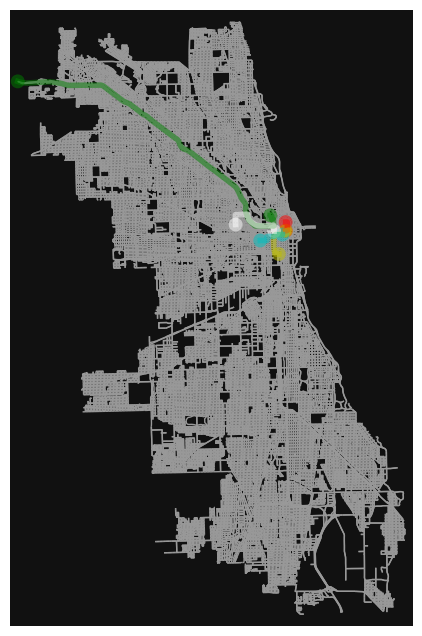

In [79]:
rc = ['r', 'y', 'c', 'g', 'white']
fig, ax = ox.plot_graph_routes(graph, top_routes, route_colors=rc, node_size=0)

In [80]:
palette = sns.color_palette("tab10", 10).as_hex()

In [81]:
geo_top_routes.reset_index(drop=True, inplace=True)

In [82]:
rc = palette[:5]
route_map = ox.plot_route_folium(graph, top_routes_taxicab[0][1], tiles='openstreetmap', color=rc[0], opacity=0.5)

for i in range(len(top_routes[1:])):
    route_map = ox.plot_route_folium(graph, top_routes_taxicab[i+1][1], route_map=route_map, color=rc[i+1], opacity=0.5)
    
for i, r in geo_top_routes.iterrows():
    folium.CircleMarker(
        location=[r['Pickup Centroid Latitude'], r['Pickup Centroid Longitude']],
        radius=10,
        popup="Centroid pickpoint coords",
        color=rc[i],
#         fill=True,
#         fill_color="#3186cc",
    ).add_to(route_map)
    folium.CircleMarker(
        location=[r['Dropoff Centroid Latitude'], r['Dropoff Centroid Longitude']],
        radius=10,
        popup="Centroid dropoff coords",
        color=rc[i],
        fill=True,
        fill_color=rc[i],
        fill_opacity=0.7,
    ).add_to(route_map)

In [83]:
route_map

## 3. City infrastructure

1. Find locations of the city infrastructure (airports, stadiums, parks, universities)
using the data and make up your own algorithm of how to find them. Find at least
6 of that kind of location.

In [84]:
def get_location_by_address(address):
    """This function returns a location as raw from an address
    will repeat until success"""
    time.sleep(1)
    try:
        return app.geocode(address).raw
    except:
        return get_location_by_address(address)

In [89]:
from geopy.geocoders import Nominatim

In [95]:
app = Nominatim(user_agent="tutorial")


In [92]:
address = "10000 West O'Hare Ave Chicago IL 60666"

In [93]:
# location = get_location_by_address(address)

KeyboardInterrupt: 

In [96]:
location = app.geocode(address).raw

AttributeError: 'NoneType' object has no attribute 'raw'

2. Find the rush hour for each of the locations – timestamp when the location had the
largest number of dropoffs and save the information into that file : "rush_hours_empty.csv"
(in attachment).

3. Visualize one day of any of the locations including that rush hour showing how
people from different places were coming to the location and then were leaving it
on an animated map.

4. When the ride finishes, it should disappear on the map. In other words, it should
look like firing neurons in the brain.

5. The map should display time.

## 4. One day of a taxi driver

1. For the taxi driver with ID (2ea4ad2950f3bbdfdcfa7adb48e0dcee49d8a714b7024342f0302
eeb9e891dfd55a6f35bb7bc7af06398fb4f55583e1659cb11b432848296bfd2b7d3084e7de1)
visualize his or her rides during the day (2019-05-31). Display the current amount
of money earned.

2. When the ride finishes, it should NOT disappear on the animated map

3. Every time the ride finishes the counter of money should be updated.

4. The map should display time.

## 5. One day of the city

1. Visualize all the rides in the city during the day (2019-05-16) on an animated map.

2. When the ride finishes, it should disappear on the map. In other words, it should
look like firing neurons in the brain.

3. The map should display time

## Bonus

- Design your visualizations as a website with interactive elements (for example, where you can choose a date or driver id, choose a location, etc).
- Try to achieve a better result with the intersection – at least 5 elements.

## Links

- https://www.kaggle.com/code/jrw2200/nyc-taxi-trips-clustering/notebook
- https://www.kaggle.com/code/bryanlambo/clustering-geolocation-data-taxi-rank-dataset

- https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1
- https://gis.stackexchange.com/questions/439823/draw-polygons-around-a-set-of-points-and-create-clusters-in-python
- https://www.youtube.com/watch?v=7m0Bq1EGPPg
- https://github.com/Coding-with-Adam/Dash-by-Plotly/tree/master/Good_to_Know/Dash2.0/Jupyter
- https://medium.com/analytics-vidhya/clustering-taxi-geolocation-data-to-predict-location-of-taxi-service-stations-pt-1-2471303e0965
- https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html
- https://medium.com/codex/clustering-geographic-data-on-an-interactive-map-in-python-60a5d13d6452
- https://medium.com/thelorry-product-tech-data/the-clustering-algorithm-with-geolocation-data-d6dd07ed36a

- https://www.youtube.com/watch?v=V9dk3EqaK3k&list=PLh3I780jNsiTnCs2LNt4ckbV-c2HatCFg&index=10
- https://docs.google.com/document/d/1X7TJUt3UI1ZBgvVqGMahUJ3REgrSZ92bHJgX6nIdABM/edit

- https://plotly.com/python/maps/

- https://medium.com/analytics-vidhya/clustering-taxi-geolocation-data-to-predict-location-of-taxi-service-stations-pt-1-2471303e0965

- https://colab.research.google.com/github/yennanliu/yennj12_blog_V2/blob/master/_notebooks/2020-04-03-nyc-taxi-eda.ipynb

- https://towardsdatascience.com/clustering-in-geospatial-applications-which-model-should-you-use-59a039332c45

- https://hal.science/hal-02947181/document
- https://medium.com/nuances-of-programming/python-django-и-osrm-маршрут-на-интерактивной-онлайн-карте-df30c6edfbc5
- https://github.com/IshanJainAI/Location-Intelligence-GeoSpatial/blob/main/30%20Python%20Libraries%20for%20Location%20Intelligence.pdf
- https://geoffboeing.com/2016/11/osmnx-python-street-networks/

- https://habr.com/ru/post/502958/

- https://github.com/nathanrooy/taxicab
- https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec